# Содержание

* [1 Подготовка окружения](#1-Подготовка-окружения)
* [2 Трансфигурация в разные формы представления данных](#2-Трансфигурация-в-разные-формы-представления-данных)
    - [2.1 Воксели](#2.1-Воксели)
    - [2.2 Облако точек](#2.2-Облако-точек)
    - [2.3 Функциональная модель](#2.3-Функциональная-модель)
    - [2.4 Карта глубины](#2.4-Карта-глубины)
* [3 Общий вывод](#3-Общий-вывод)

# Лабораторная работа №2: Конфигурация меша из сферы

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tidalinn/mai_term03_artificial_intelligence_course/blob/main/02_laboratory_work.ipynb)

>GPU activation: Runtime → Change runtime type → T4 GPU

**Задача:** трансфигурировать 3D-модель в разные формы представления данных по статье [3D ML. Часть 1: формы представления 3D-данных](https://habr.com/ru/companies/itmai/articles/503358/).

**Источники данных:** [sketchfab.com](https://sketchfab.com/)

* [`black_dragon`](https://sketchfab.com/3d-models/black-dragon-73b252c7e24d452b9db626abfbecc2a5)
* **[`dragon_without_wings`](https://sketchfab.com/3d-models/mcfarlanes-dragons-eternal-clan-wo-wings-98fa5a879a9c46fc82f6160f84428304)** - выбран для проведения экспериментов
* [`ice_dragon`](https://sketchfab.com/3d-models/ice-dragon-4ef3ac18a3834ba1bda8933d04c61f45)

**Описание данных:** 3D-модели драконов.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Установка библиотек:

In [1]:
!pip install git+https://github.com/facebookresearch/pytorch3d.git

  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-hf01rxj5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-hf01rxj5
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 8a27590c5fd6aba4d138660614c7a18832701671
  Preparing metadata (setup.py) ... done


Импорт библиотек:

In [2]:
import numpy as np

import os
from typing import List, Dict
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch

from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance, mesh_edge_loss, \
                           mesh_laplacian_smoothing, mesh_normal_consistency

Игнорирование предупреждений:

In [3]:
import warnings
warnings.filterwarnings('ignore')

Сохранение выполняемого устройства:

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('Current device:', device)

Current device: cuda:0


Определение местоположения тетради:

In [5]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

print('Current notebook in Colab:', IN_COLAB)

Current notebook in Colab: True


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Деформация меша

Задание функции, выводящей 3D-представление объекта:

In [6]:
def plot_point_cloud(mesh, title: str = '', fig = None, position: List[int] = None) -> None:
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)

    if fig is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')
    else:
        row, col, index = position
        ax = fig.add_subplot(row, col, index, projection='3d')

    ax.scatter3D(x, z, -y, s=1)

    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')

    ax.set_title(title)

    ax.view_init(190, 30)

    if fig is None:
        plt.show()

Задание функции, выводящей несколько 3D-объектов:

In [7]:
def plot_multiple_plots(meshes, n_cols: int = 2) -> None:
    n_rows = len(meshes) // n_cols
    n_rows = n_rows if len(meshes) % n_cols == 0 else n_rows + 1

    fig = plt.figure(figsize=(12, 4 * n_rows))

    for index, (name, mesh) in enumerate(meshes):
        plot_point_cloud(mesh, name, fig=fig, position=[n_rows, n_cols, index + 1])

    plt.show()

---

### 2.1 Задание моделей

Задание пути до целевого меша:

In [8]:
if IN_COLAB:
    path_model = ('/content/dragon_without_wings.obj')
else:
    path_model = ('./3d_models/dragon_without_wings.obj')

print('Path to model:', path_model)

Path to model: /content/dragon_without_wings.obj


Загрузка и нормализация меша:

In [9]:
verts, faces, aux = load_obj(path_model)

faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

mesh_dragon = Meshes(verts=[verts], faces=[faces_idx])

Создание меша сферы:

In [10]:
mesh_sphere = ico_sphere(4, device)

Выведение на экран мешей:

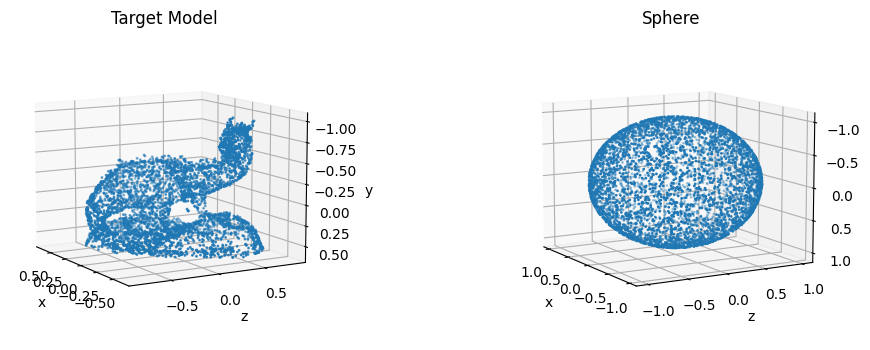

In [11]:
plot_multiple_plots([('Target Model', mesh_dragon), ('Sphere', mesh_sphere)])

---

### 2.2 Обучение модели машинного обучения

Взвешенная сумма функций ошибок и регуляризаторов:

$$ Loss = \omega_c L_{cham} + \omega_n L_{norm} + \omega_e L_{edge} + \omega_l L_{Lap} $$

Деформация модели:

* Модель сферы - исходное приближение.
* Модель машинного обучения генерирует исходное приближение.
* Модель дракона - целевая модель.

<br>

---

<br>

**Chamber loss / distance**

>Показывает, насколько вершины одной полигональной модели (облака точек) близки к вершинам другой полигональной модели (облаку точек), и следовательно, подлежат минимизации.
>
>Недостатками являются чувствительность к выбросам и эффект перекрытия полигонов.

$$ L_{cham} (P, Q) = |P|^{-1} \sum_{(p, q) \in \Lambda_{P, Q}} ||p - q||^2 + \sum_{(q, p) \in \Lambda_{Q, P}} ||q - p||^2 $$

$$ \Lambda_(P, Q) = \big\{ (p, \begin{equation}
   \underset{q \in Q}{\arg\min}
\end{equation} ||p - q||): p \in P \big\} $$

где:

* $ P, Q $ - точечные множества

<br>

**Normal loss / distance**

>Показывает, насколько сильно различаются поля нормалей у двух полигональных моделей - при минимизации критерия уменьшаются углы между соответствующими нормалями.
>
>Недостатками являются чувствительность к выбросам и эффект перекрытия полигонов.

$$ L_{norm} (P, Q) = -|P|^{-1} \sum_{(p, q) \in \Lambda_{P, Q}} |u_q * u_p| - |Q|^{-1} \sum_{(q, p) \in \Lambda_{Q, P}} |u_p * u_q| $$

где:

* $ P, Q $ - точечные множества

<br>

**Edge loss / regulizer**

>Используется в качестве специального регуляризатора формы итогового меша вместе с Chamfer loss и Normal loss.

$$ L_{edge} (V, E) = \frac {1}{|E|} \sum_{(v, v') \in E} ||v - v'||^2, E \subseteq V \times V $$

где:

* $ V $ - множество вершин полигональной модели.
* $ E $ - множество рёбер модели.

<br>

**Laplacian loss / regularizer**

>Применяется к задачам сглаживания, деформирования и конкатенации меша.

$$ L_{Lap} (x) = \sum_x ||\sigma_p' - \sigma_p||_2^2 $$

---

Задание функции, выводящей значения функций потерь:

In [12]:
def plot_losses(losses: Dict[str, List[float]]) -> None:
    fig = plt.figure(figsize=(10, 4))
    plt.title('Loss functions\n', fontsize=12)

    for name, loss in losses.items():
        plt.plot(loss, label=name)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

Задание функции обучения модели:

In [13]:
def train_model(mesh_init,
                mesh_target,
                n_epochs: int,
                w_chamfer: float = 1.0,
                w_edge: float = 1.0,
                w_normal: float = 0.01,
                w_laplacian: float = 0.1,
                plot_period: int = 250,
                n_cols: int = 4) -> Dict[str, List[float]]:

    losses = {
        'chamfer_loss': [],
        'laplacian_loss': [],
        'edge_loss': [],
        'normal_loss': []
    }

    # plot process
    n_rows = n_epochs // plot_period
    n_rows = n_rows if n_epochs % plot_period == 0 else n_rows + 1
    index = 0

    fig = plt.figure(figsize=(12, 4 * n_rows))


    #set up optimizer
    deform_verts = torch.full(
        mesh_sphere.verts_packed().shape,
        0.0,
        device=device,
        requires_grad=True
    )

    optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)


    loop = tqdm(range(n_epochs))

    # training
    for epoch in loop:
        optimizer.zero_grad()

        mesh_updated = mesh_init.offset_verts(deform_verts)

        sample_trg = sample_points_from_meshes(mesh_target, 5000)
        sample_src = sample_points_from_meshes(mesh_updated, 5000)

        # calculate losses
        loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
        loss_edge = mesh_edge_loss(mesh_updated)
        loss_normal = mesh_normal_consistency(mesh_updated)
        loss_laplacian = mesh_laplacian_smoothing(mesh_updated, method="uniform")

        total_loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
        loop.set_description('total_loss = %.6f' % total_loss)

        # save losses
        losses['chamfer_loss'].append(float(loss_chamfer.detach().cpu()))
        losses['edge_loss'].append(float(loss_edge.detach().cpu()))
        losses['normal_loss'].append(float(loss_normal.detach().cpu()))
        losses['laplacian_loss'].append(float(loss_laplacian.detach().cpu()))

        # plot process
        if epoch % plot_period == 0:
            plot_point_cloud(mesh_updated, f'Epoch: {epoch}', fig=fig, position=[n_rows, n_cols, index + 1])
            index += 1

        total_loss.backward()
        optimizer.step()

    plt.show()

    return losses

---

Обучение модели:

  0%|          | 0/2000 [00:00<?, ?it/s]

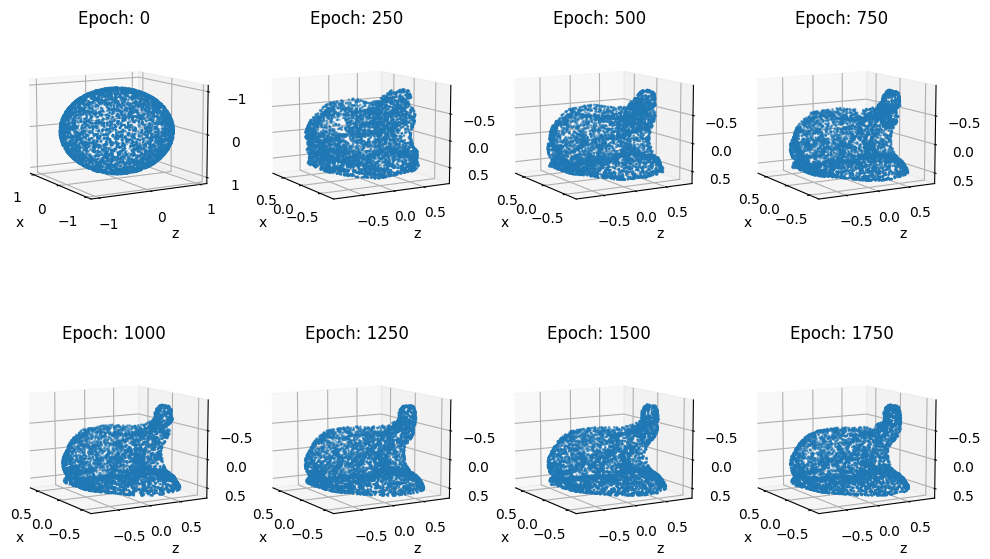

In [14]:
losses = train_model(mesh_sphere, mesh_dragon, n_epochs=2000)

Построение графика значений функций потерь:

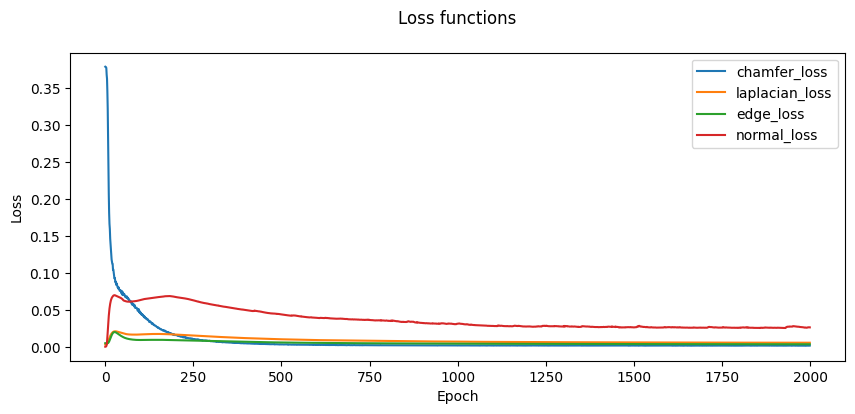

In [15]:
plot_losses(losses)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Общий вывод

В ходе произведённых экспериментов был изучен процесс обучения модели машинного обучения, генерирующей из исходного меша целевой объект.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        Наверх ↑
    </a>
</div>